# En este notebook se analiza el comportamiento de los diferentes grupos de postulantes de a cuerdo a sus edades. 
## Para esto se toman 3 grupos de postulantes: 
### - Los menores de 23 años (18 - 24 años).
### - Los que se encuentran entre 25 años y 34 años inclusive (23 - 34 años).
### - Los mayores de 35 años.

In [1]:
# Se importan las librerías necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import sys
reload(sys) # now sys.setdefaultencoding() is visible
sys.setdefaultencoding('utf-8')
%run double-pendulum.py

pd.options.mode.chained_assignment = None

In [2]:
# Se leen los dataframes.
postulantesEducacion = pd.read_csv('../Data/fiuba_1_postulantes_educacion.csv')
postulantesGeneroYEdad = pd.read_csv('../Data/fiuba_2_postulantes_genero_y_edad.csv')
oportunidadVistas = pd.read_csv('../Data/fiuba_3_vistas.csv')
oportunidadPostulaciones = pd.read_csv('../Data/fiuba_4_postulaciones.csv')
avisosOnline = pd.read_csv('../Data/fiuba_5_avisos_online.csv')
avisosDetalle = pd.read_csv('../Data/fiuba_6_avisos_detalle.csv')

In [3]:
# Elimino los postulantes cuyos ids o fechas de nacimiento son nulas.

# Elimino las filas que no tengan id del postulante.
postulantesEducacion.dropna(subset = ['idpostulante'], inplace = True)
postulantesGeneroYEdad.dropna(subset = ['idpostulante'], inplace = True)

# Creo un nuevo dataframe con los postulantes que tengan fecha de nacimiento.
postulantesConEdad = postulantesGeneroYEdad.dropna(subset=['fechanacimiento'])

In [4]:
# Creo una nueva columna con la edad del postulante. Descarto los postulantes cuyas edades no pueden ser averiguadas.

# Paso la columna fecha de nacimiento a un datetime.
postulantesConEdad['fechanacimiento'] = pd.to_datetime(postulantesConEdad['fechanacimiento'], errors='coerce')

# Creo la columna edad como diferencia entre la fecha actual y la fecha de nacimiento.
fechaActual = pd.Timestamp(datetime.datetime.now())
postulantesConEdad['edad'] = (fechaActual - postulantesConEdad['fechanacimiento']).astype('<m8[Y]')

# Elimino los postulantes sin edades.
postulantesConEdad.dropna(subset = ['edad'], inplace = True)

# Descarto la columna fecha de nacimiento.
postulantesConEdad.drop('fechanacimiento', 1, inplace = True)

In [5]:
# Creo un unico dataframe para los datos del postulante.

# Renombro las columnas del dataframe de educacion a algo mas descriptivo.
postulantesEducacion.rename(columns={'nombre': 'niveleducativo', 'estado': 'estadoniveleducation'}, inplace = True)

# Hago un left join tomando todos los registros del dataframe que contiene la edad.
postulantes = pd.merge(postulantesConEdad, postulantesEducacion, on = 'idpostulante', how = 'left')

# Tomo los campos relacionado a lo educativo, los uno en uno solo y elimino las dos columnas no necesarias.
postulantes['educacion'] = postulantes['niveleducativo'] + '-' + postulantes['estadoniveleducation']
postulantes.drop('niveleducativo', 1, inplace = True)
postulantes.drop('estadoniveleducation', 1, inplace = True)

In [6]:
# Agrego al dataframe de detalles de aviso una columna que diga especifique si sigue online o esta offline.

# Agrego una columna booleana al avisos online para que despues quede en el left merge.
avisosOnline['online'] = True

# Hago el merge entre los detalles y la tabla de online, luego completo los Nan de los offline con False.
avisos = pd.merge(avisosDetalle, avisosOnline, on = 'idaviso', how = 'left')
avisos['online'].fillna(False, inplace = True)

# Teniendo los dataframe de avisos, postulantes, vistas de aviso y postulaciones de aviso se procede a dar respuestas a las siguientes preguntas:

### 1) ¿Cuáles son las areas de trabajo mas visitadas por los diferentes grupos? ¿Y las menos visitadas?
### 2) ¿Cuáles son las areas de trabajo que reciben mas postulaciones de los diferentes grupos?

## Antes de empezar a responder las diferentes preguntas vamos a hacer un análisis demográfico de cada grupo:
- Cuantos postulantes hay en cada grupo.
- Como se conforman los diferentes grupos en cuanto a sexo.
- Cual es el nivel educacional de cada grupo y de cada grupo dividido por sexo.

In [7]:
# TODO: Gastón - Aca va el análisis demográfico.

### Antes de empezar a responder las preguntas creo los dataframe que voy a estar utilizando en el desarrollo de las mismas.

In [8]:
# Renombro la columna idAviso de las vistas a idaviso sin mayuscula así queda homogeneo.
oportunidadVistas.rename(columns={'idAviso': 'idaviso'}, inplace = True)

# Dataframe de vistas.
vistas = pd.merge(oportunidadVistas, avisos, on = 'idaviso', how = 'left')
vistas = pd.merge(vistas, postulantes, on = 'idpostulante', how = 'left')

# Dataframe de postulaciones.
postulaciones = pd.merge(oportunidadPostulaciones, avisos, on = 'idaviso', how = 'left')
postulaciones = pd.merge(vistas, postulantes, on = 'idpostulante', how = 'left')

In [44]:
# Para los siguientes análisis voy a tener en cuenta la cantidad de avisos por area.
cantidadAvisosArea = avisos[['nombre_area']]

# Elimino los registros que no tengan nombre de area.
cantidadAvisosArea.dropna(subset = ['nombre_area'], inplace = True)

# Creo una columna con todos 1 que va a servir de contador, luego realizo el groupby y por ultimo el ordenamiento.
cantidadAvisosArea['cantidadavisos'] = 1
cantidadAvisosArea = cantidadAvisosArea.groupby(['nombre_area'], as_index = False).count()
cantidadAvisosArea = cantidadAvisosArea.sort_values(by = 'cantidadavisos', ascending = False)

## 1 - ¿Cuáles son las areas de trabajo mas visitadas por los diferentes grupos? ¿Y las menos visitadas?

In [12]:
# Tomo del dataframe de vistas el nombre de area y la edad solamente.
areaVisitadas = vistas[['nombre_area', 'edad']]

# Agrego una columna cantidad para que luego haga las veces de contador en el group by.
areaVisitadas['cantidad'] = 1

# Divido el dataframe en los 3 grupos de edades.
areaVisitadas1 = areaVisitadas[areaVisitadas['edad'] < 25]
areaVisitadas1.drop('edad', 1, inplace = True)

areaVisitadas2 = areaVisitadas[(areaVisitadas['edad'] >= 25) & (areaVisitadas['edad'] < 35)]
areaVisitadas2.drop('edad', 1, inplace = True)

areaVisitadas3 = areaVisitadas[areaVisitadas['edad'] >= 35]
areaVisitadas3.drop('edad', 1, inplace = True)

# Agrupo segun el area.
areaVisitadas1 = areaVisitadas1.groupby(['nombre_area'], as_index = False).count()
areaVisitadas2 = areaVisitadas2.groupby(['nombre_area'], as_index = False).count()
areaVisitadas3 = areaVisitadas3.groupby(['nombre_area'], as_index = False).count()

# Ordeno de mayor a menor.
areaVisitadas1 = areaVisitadas1.sort_values(by = 'cantidad', ascending = False)
areaVisitadas2 = areaVisitadas2.sort_values(by = 'cantidad', ascending = False)
areaVisitadas3 = areaVisitadas3.sort_values(by = 'cantidad', ascending = False)

# Tomo las 10 areas mas visitadas y las menos visitadas de cada grupo.
areaMasVisitadas1 = areaVisitadas1.head(10)
areaMenosVisitadas1 = areaVisitadas1.tail(10)

areaMasVisitadas2 = areaVisitadas2.head(10)
areaMenosVisitadas2 = areaVisitadas2.tail(10)

areaMasVisitadas3 = areaVisitadas3.head(10)
areaMenosVisitadas3 = areaVisitadas3.tail(10)

# En este analisis se va a analizar la relacion entre la cantidad de avisos de un area y la cantidad de visitas 
# a los avisos de dicha area.

# Agrego a los dataframes de visitas de areas el contador de la cantidad de avisos del area en cuestion.
cantidadAvisosAreaMasVisitadas1 = pd.merge(areaMasVisitadas1, cantidadAvisosArea, on = 'nombre_area', how = 'left')
cantidadAvisosAreaMasVisitadas2 = pd.merge(areaMasVisitadas2, cantidadAvisosArea, on = 'nombre_area', how = 'left')
cantidadAvisosAreaMasVisitadas3 = pd.merge(areaMasVisitadas3, cantidadAvisosArea, on = 'nombre_area', how = 'left')

cantidadAvisosAreaMenosVisitadas1 = pd.merge(areaMenosVisitadas1, cantidadAvisosArea, on = 'nombre_area', how = 'left')
cantidadAvisosAreaMenosVisitadas2 = pd.merge(areaMenosVisitadas2, cantidadAvisosArea, on = 'nombre_area', how = 'left')
cantidadAvisosAreaMenosVisitadas3 = pd.merge(areaMenosVisitadas3, cantidadAvisosArea, on = 'nombre_area', how = 'left')

### 1.1 - Análisis para el grupo de 18 a 24 años.

#### 1.1.1 - Tabla con la lista de las areas mas visitadas por el grupo de 18 a 24 años.

In [19]:
areaMasVisitadas1

,nombre_area,cantidad
149,Ventas,74710
2,Administración,50579
123,Recepcionista,33343
13,Atención al Cliente,28784
24,Comercial,24378
21,Call Center,19742
116,Producción,19357
142,Telemarketing,18249
143,Tesorería,11662
22,Camareros,8766


#### 1.1.2 - Grafico que muestra las areas más vistadas para el grupo de 18 a 24 años.

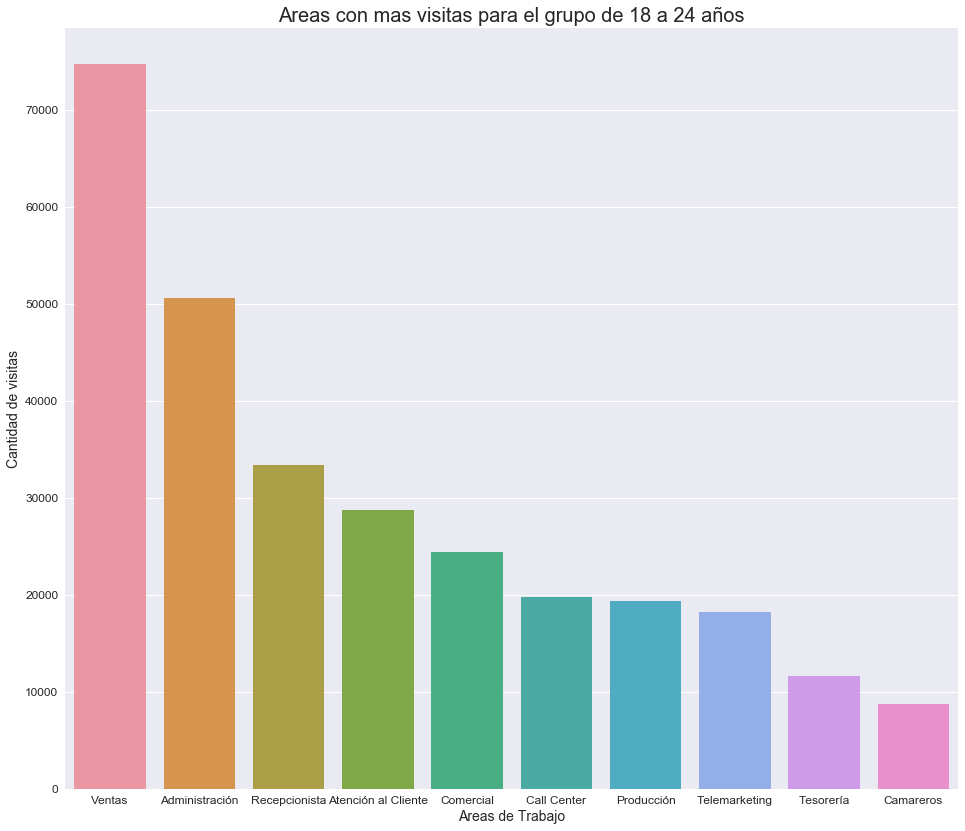

In [74]:
plt.subplots(figsize = (16, 14))
areaMasVisitadas1Plot = sns.barplot(x = areaMasVisitadas1['nombre_area'], y = areaMasVisitadas1['cantidad'], orient = 'v')
areaMasVisitadas1Plot.set_title("Areas con mas visitas para el grupo de 18 a 24 años", fontsize = 20)
areaMasVisitadas1Plot.set_ylabel("Cantidad de visitas", fontsize = 14)
areaMasVisitadas1Plot.set_xlabel("Areas de Trabajo", fontsize = 14)
areaMasVisitadas1Plot.tick_params(labelsize = 12)
plt.show()

#### 1.1.3 - Tabla con la cantidad de avisos para las areas mas visitadas por el grupo de 18 a 24 años.

In [22]:
cantidadAvisosAreaMasVisitadas1

,nombre_area,cantidad,cantidadavisos
0,Ventas,74710,1659
1,Administración,50579,901
2,Recepcionista,33343,151
3,Atención al Cliente,28784,347
4,Comercial,24378,983
5,Call Center,19742,191
6,Producción,19357,821
7,Telemarketing,18249,138
8,Tesorería,11662,137
9,Camareros,8766,48


#### 1.1.4 - Grafico que muestra la cantidad de avisos de las areas mas visitadas por el grupo de 18 a 24 años.

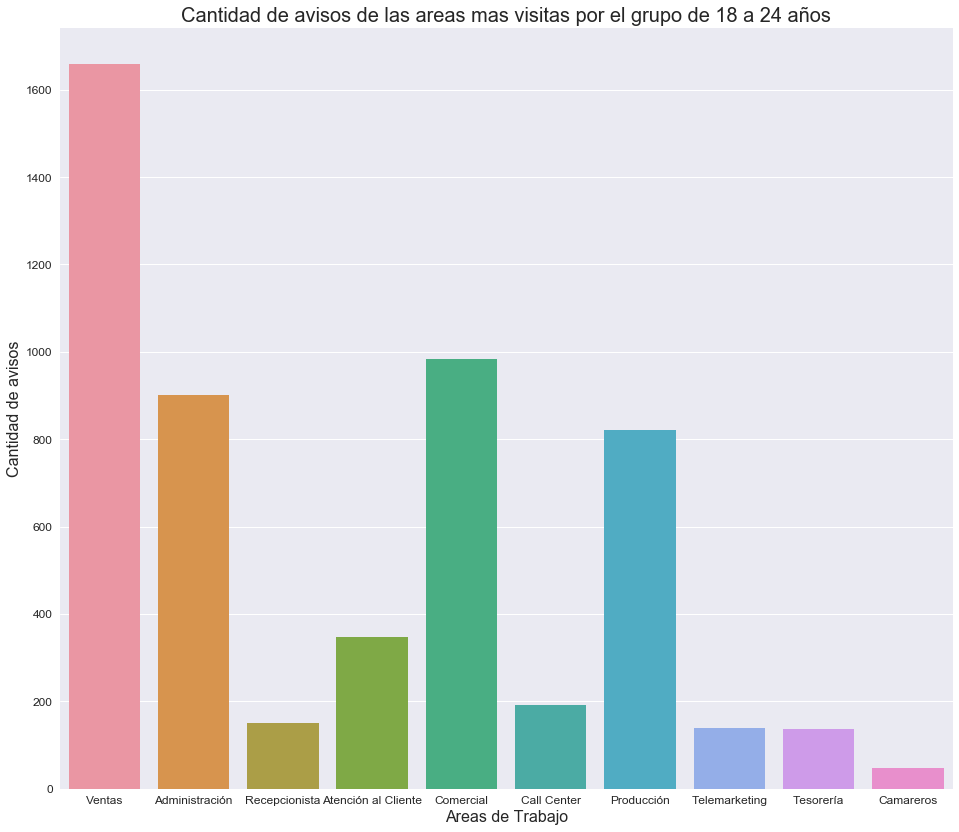

In [75]:
plt.subplots(figsize = (16, 14))
cantidadAvisosAreaMasVisitadaPlot1 = sns.barplot(x = cantidadAvisosAreaMasVisitadas1['nombre_area'], y = cantidadAvisosAreaMasVisitadas1['cantidadavisos'], orient = 'v')
cantidadAvisosAreaMasVisitadaPlot1.set_title("Cantidad de avisos de las areas mas visitas por el grupo de 18 a 24 años", fontsize = 20)
cantidadAvisosAreaMasVisitadaPlot1.set_ylabel("Cantidad de avisos", fontsize = 16)
cantidadAvisosAreaMasVisitadaPlot1.set_xlabel("Areas de Trabajo", fontsize = 16)
cantidadAvisosAreaMasVisitadaPlot1.tick_params(labelsize = 12)
plt.show()

#### 1.1.5 - Grafico acumulado con las cantidad de visitas y publicaciones de las areas mas vistas para el grupo de 18 a 24 años.

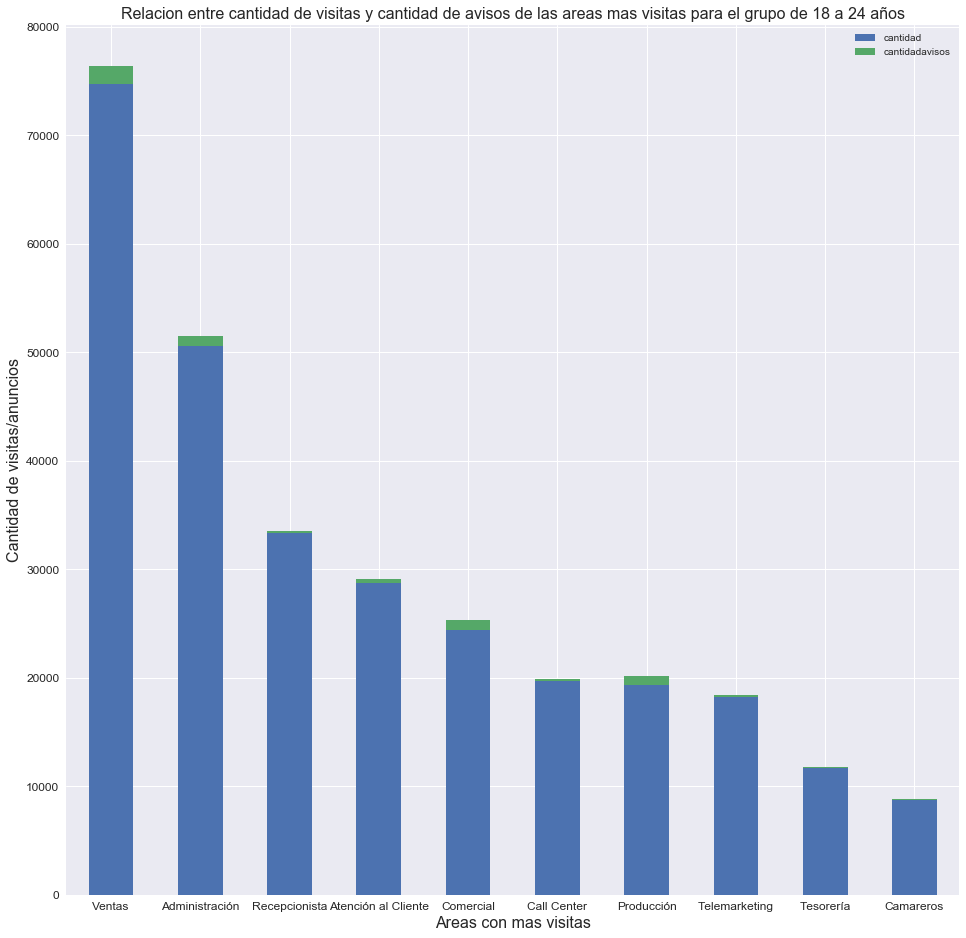

In [76]:
areaMasVisitadasPlotAcumulado1 = cantidadAvisosAreaMasVisitadas1.set_index('nombre_area').plot.bar(stacked = True, figsize = (16, 16), fontsize = 12, rot = 0)
areaMasVisitadasPlotAcumulado1.set_xlabel("Areas con mas visitas", fontsize = 16)
areaMasVisitadasPlotAcumulado1.set_ylabel("Cantidad de visitas/anuncios", fontsize = 16)
areaMasVisitadasPlotAcumulado1.set_title("Relacion entre cantidad de visitas y cantidad de avisos de las areas mas visitas para el grupo de 18 a 24 años", fontsize = 16)
plt.show()

#### 1.1.6 - Tabla con la lista de las areas menos visitadas por el grupo de 18 a 24 años.

In [46]:
areaMenosVisitadas1

,nombre_area,cantidad
25,Comercio Exterior,11
31,Comunicaciones Externas,10
85,Ingeniería de Ventas,10
151,Veterinaria,10
87,Ingeniería en Minas,8
105,Negocios Internacionales,7
145,Traduccion,7
88,Ingeniería en Petróleo y Petroquímica,7
43,Data Warehousing,6
102,Medio Ambiente,3


#### 1.1.7 - Grafico que muestra las areas menos vistadas para el grupo de 18 a 24 años.

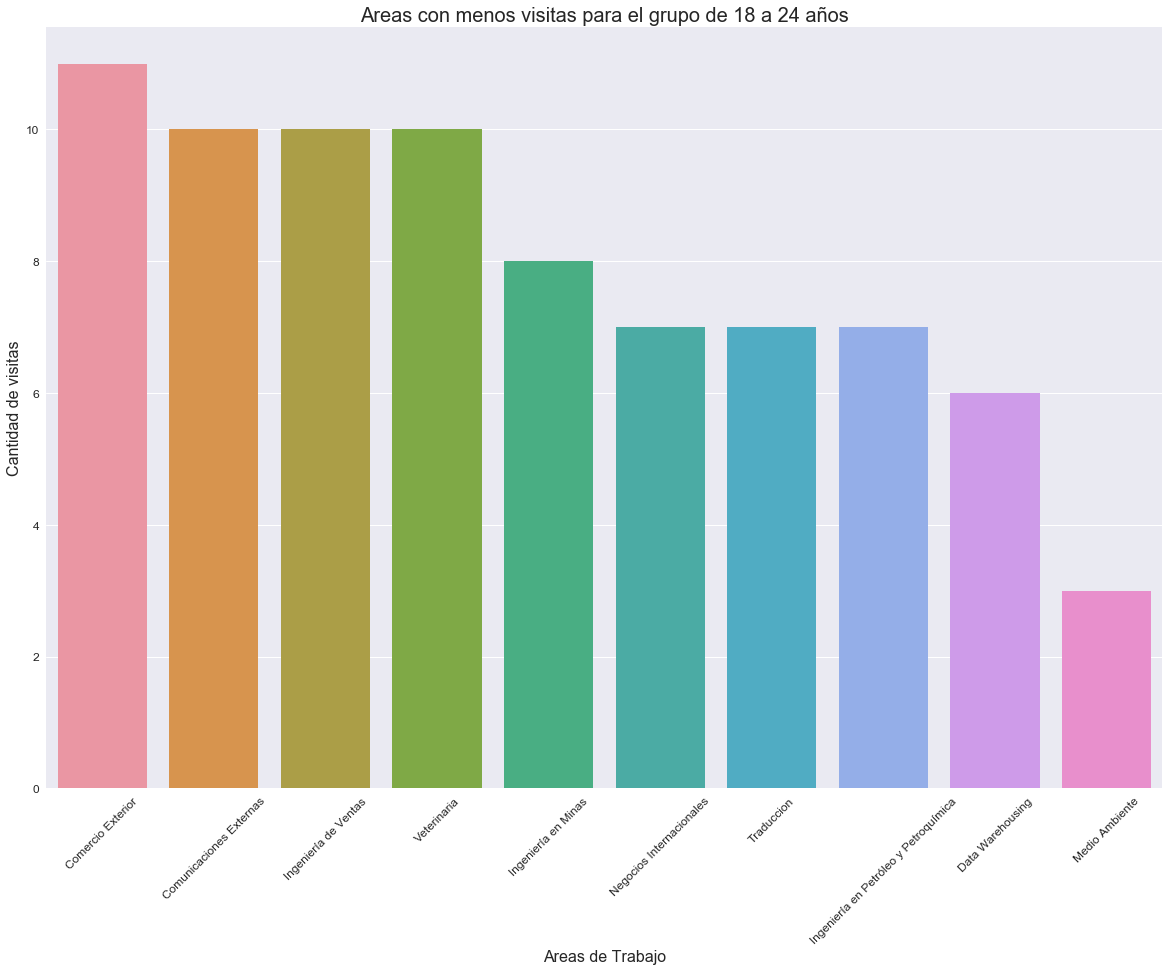

In [78]:
plt.subplots(figsize = (20, 14))
areaMenosVisitadas1Plot = sns.barplot(x = areaMenosVisitadas1['nombre_area'], y = areaMenosVisitadas1['cantidad'], orient = 'v')
areaMenosVisitadas1Plot.set_title("Areas con menos visitas para el grupo de 18 a 24 años", fontsize = 20)
areaMenosVisitadas1Plot.set_ylabel("Cantidad de visitas", fontsize = 16)
areaMenosVisitadas1Plot.set_xlabel("Areas de Trabajo", fontsize = 16)
areaMenosVisitadas1Plot.set_xticklabels(areaMenosVisitadas1Plot.get_xticklabels(), rotation = 45)
areaMenosVisitadas1Plot.tick_params(labelsize = 12)
plt.show()

#### 1.1.8 - Tabla con la cantidad de avisos para las areas menos visitadas para el grupo de 18 a 24 años.

In [79]:
cantidadAvisosAreaMenosVisitadas1

,nombre_area,cantidad,cantidadavisos
0,Comercio Exterior,11,7
1,Comunicaciones Externas,10,1
2,Ingeniería de Ventas,10,16
3,Veterinaria,10,6
4,Ingeniería en Minas,8,6
5,Negocios Internacionales,7,3
6,Traduccion,7,1
7,Ingeniería en Petróleo y Petroquímica,7,1
8,Data Warehousing,6,2
9,Medio Ambiente,3,5


#### 1.1.9 - Grafico que muestra la cantidad de avisos de las areas menos visitadas por el grupo de 18 a 24 años.

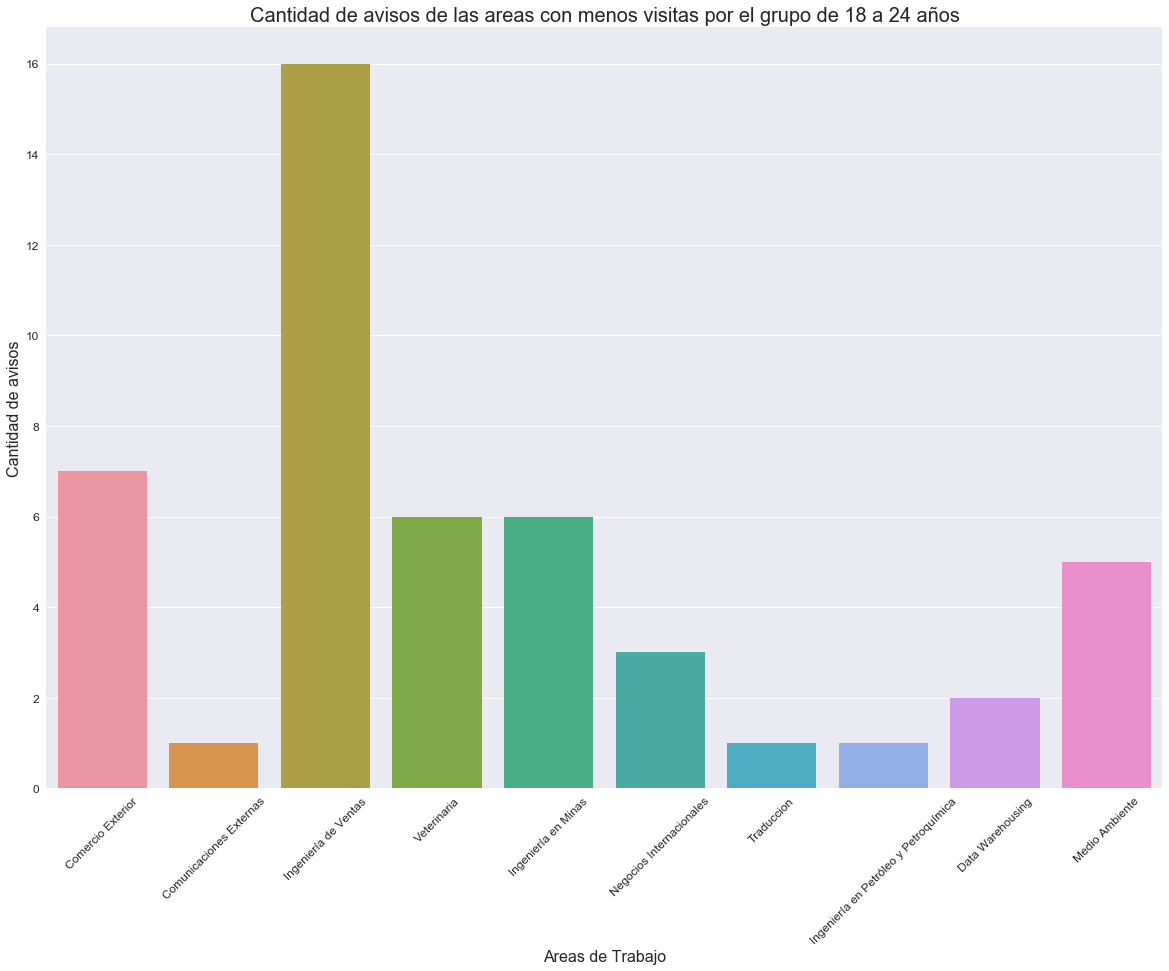

In [80]:
plt.subplots(figsize = (20, 14))
cantidadAvisosAreaMenosVisitadaPlot1 = sns.barplot(x = cantidadAvisosAreaMenosVisitadas1['nombre_area'], y = cantidadAvisosAreaMenosVisitadas1['cantidadavisos'], orient = 'v')
cantidadAvisosAreaMenosVisitadaPlot1.set_title("Cantidad de avisos de las areas con menos visitas por el grupo de 18 a 24 años", fontsize = 20)
cantidadAvisosAreaMenosVisitadaPlot1.set_ylabel("Cantidad de avisos", fontsize = 16)
cantidadAvisosAreaMenosVisitadaPlot1.set_xlabel("Areas de Trabajo", fontsize = 16)
cantidadAvisosAreaMenosVisitadaPlot1.set_xticklabels(cantidadAvisosAreaMenosVisitadaPlot1.get_xticklabels(), rotation = 45)
cantidadAvisosAreaMenosVisitadaPlot1.tick_params(labelsize = 12)
plt.show()

#### 1.1.10 - Grafico acumulado con las cantidad de visitas y avisos de las areas menos vistas para el grupo de 18 a 24 años.

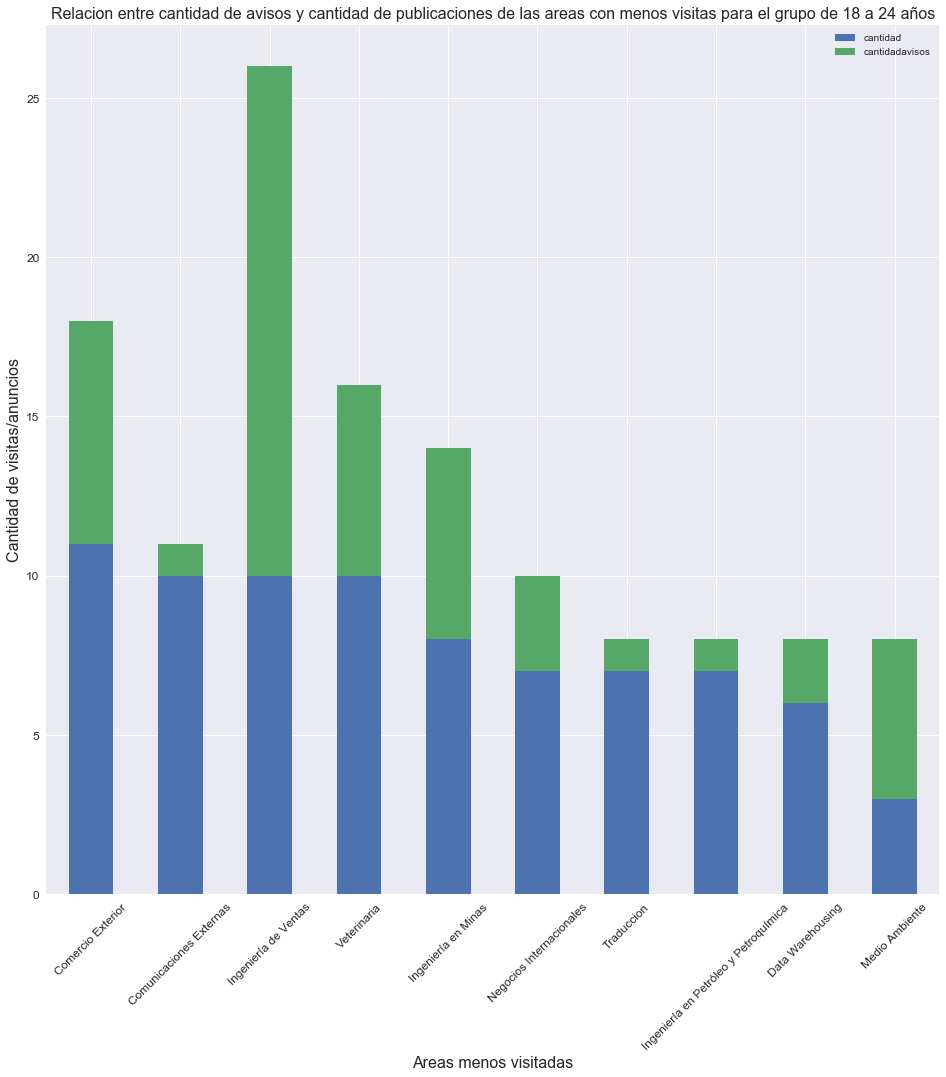

In [83]:
areaMenosVisitadasPlotAcumulado1 = cantidadAvisosAreaMenosVisitadas1.set_index('nombre_area').plot.bar(stacked = True, figsize = (16, 16), fontsize = 12, rot = 45)
areaMenosVisitadasPlotAcumulado1.set_xlabel("Areas menos visitadas", fontsize = 16)
areaMenosVisitadasPlotAcumulado1.set_ylabel("Cantidad de visitas/anuncios", fontsize = 16)
areaMenosVisitadasPlotAcumulado1.set_title("Relacion entre cantidad de avisos y cantidad de publicaciones de las areas con menos visitas para el grupo de 18 a 24 años", fontsize = 16)
plt.show()

In [ ]:
# Tabla con la lista de las areas menos visitadas por el grupo de 25 a 34 años.
areaMenosVisitadas2

In [ ]:
# Tabla con la lista de las areas mas visitadas por el grupo de 25 a 34 años.
areaMasVisitadas2

In [ ]:
# Tabla con la lista de las areas mas visitadas por el grupo de mas de 35 años.
areaMasVisitadas3

In [ ]:
# Tabla con la lista de las areas menos visitadas por el grupo de 18 a 24 años.
areaMenosVisitadas1

In [ ]:
# Tabla con la lista de las areas menos visitadas por el grupo de mas de 35 años.
areaMenosVisitadas3

In [ ]:
# Grafico que muestra las areas más vistadas para el grupo de 25 a 34 años.
plt.subplots(figsize = (16, 14))
areaMasVisitadas2Plot = sns.barplot(x = areaMasVisitadas2['nombre_area'], y = areaMasVisitadas2['cantidad'], orient = 'v')
areaMasVisitadas2Plot.set_title("Areas con mas vistas para el grupo de 25 a 34 años", fontsize = 20)
areaMasVisitadas2Plot.set_xlabel("Cantidad de Postulaciones", fontsize = 12)
areaMasVisitadas2Plot.set_ylabel("Areas de Trabajo", fontsize = 12)
plt.show()

In [ ]:
# Grafico que muestra las areas más vistadas para el grupo de mas de 35.
plt.subplots(figsize = (16, 14))
areaMasVisitadas3Plot = sns.barplot(x = areaMasVisitadas3['nombre_area'], y = areaMasVisitadas3['cantidad'], orient = 'v')
areaMasVisitadas3Plot.set_title("Areas con mas vistas para el grupo de mas de 35 años", fontsize = 20)
areaMasVisitadas3Plot.set_xlabel("Cantidad de Postulaciones", fontsize = 12)
areaMasVisitadas3Plot.set_ylabel("Areas de Trabajo", fontsize = 12)
plt.show()

In [ ]:
# Grafico que muestra las areas menos vistadas para el grupo de 25 a 34 años.
plt.subplots(figsize = (20, 14))
areaMenosVisitadas2Plot = sns.barplot(x = areaMenosVisitadas2['nombre_area'], y = areaMenosVisitadas2['cantidad'], orient = 'v')
areaMenosVisitadas2Plot.set_xticklabels(areaMenosVisitadas2Plot.get_xticklabels(), rotation = 45)
areaMenosVisitadas2Plot.set_title("Areas con menos vistas para el grupo de 25 a 34 años", fontsize = 20)
areaMenosVisitadas2Plot.set_xlabel("Cantidad de Postulaciones", fontsize = 12)
areaMenosVisitadas2Plot.set_ylabel("Areas de Trabajo", fontsize = 12)
plt.show()

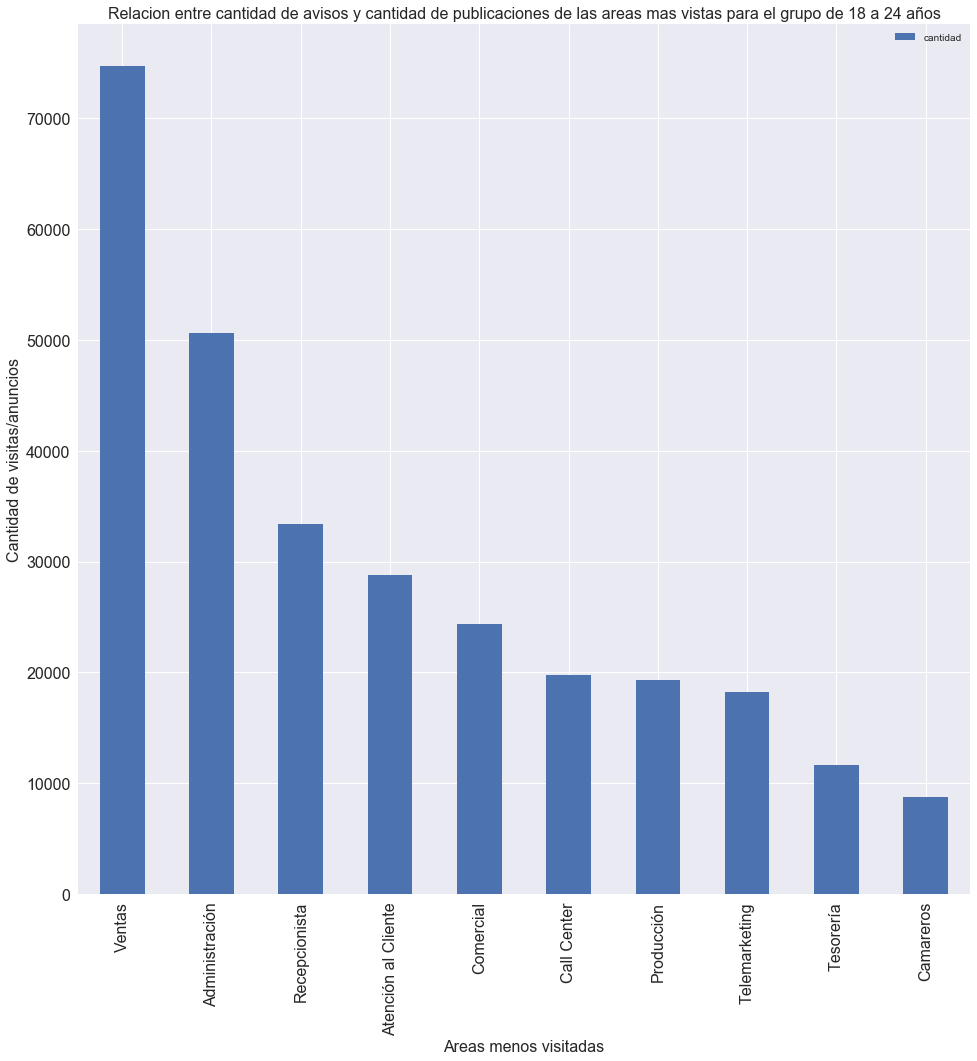

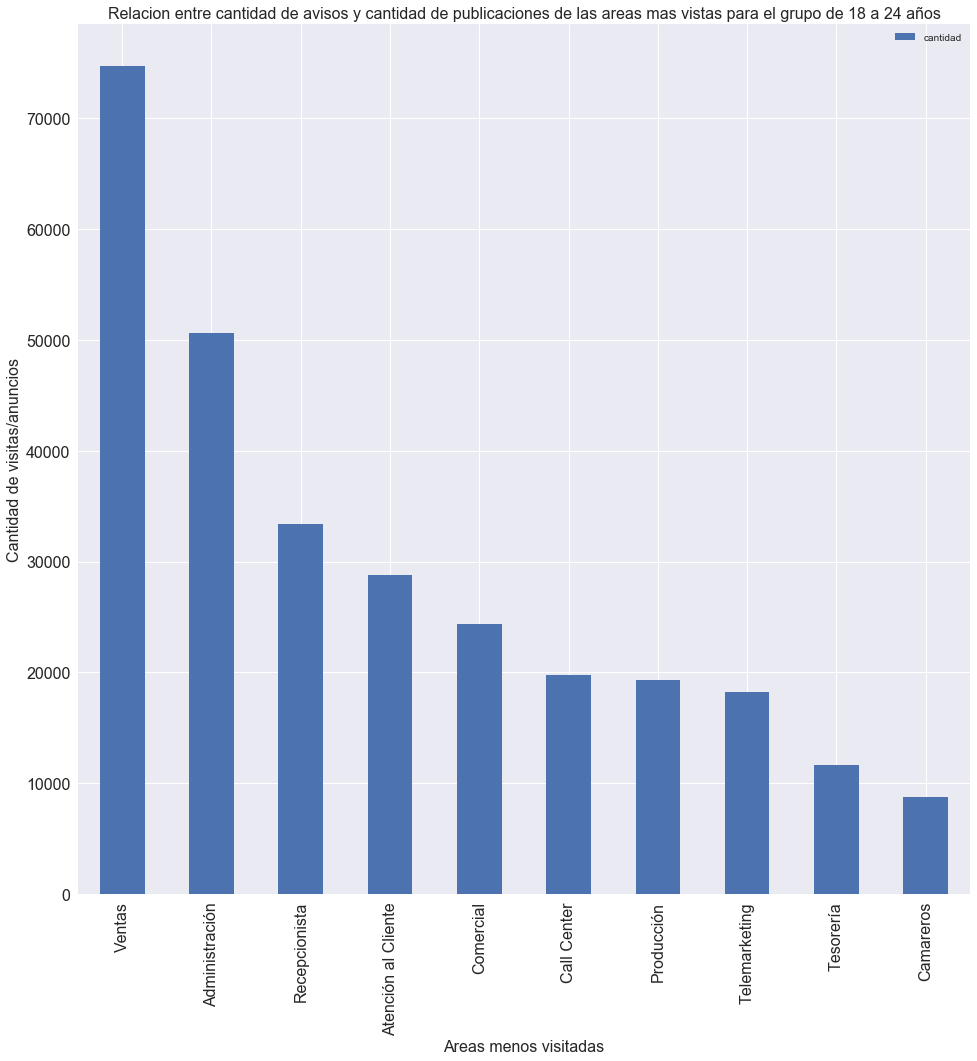

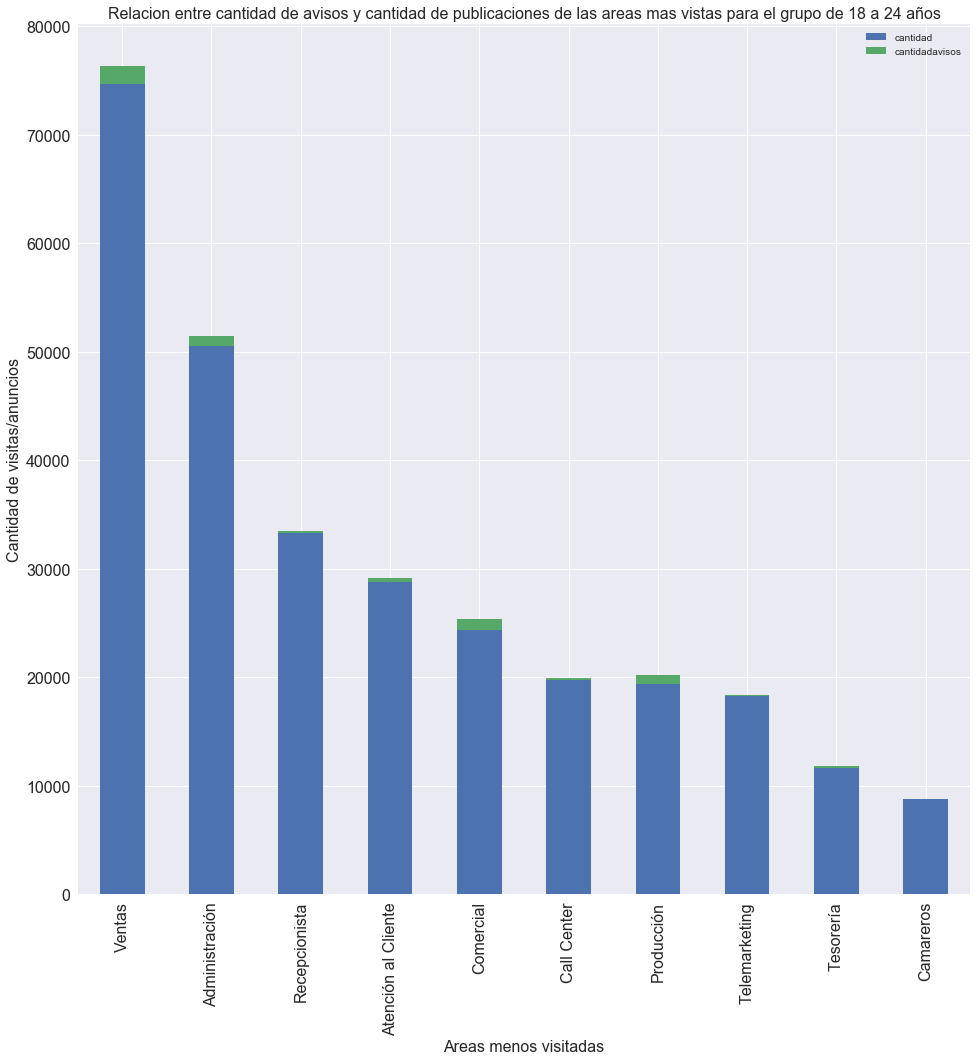

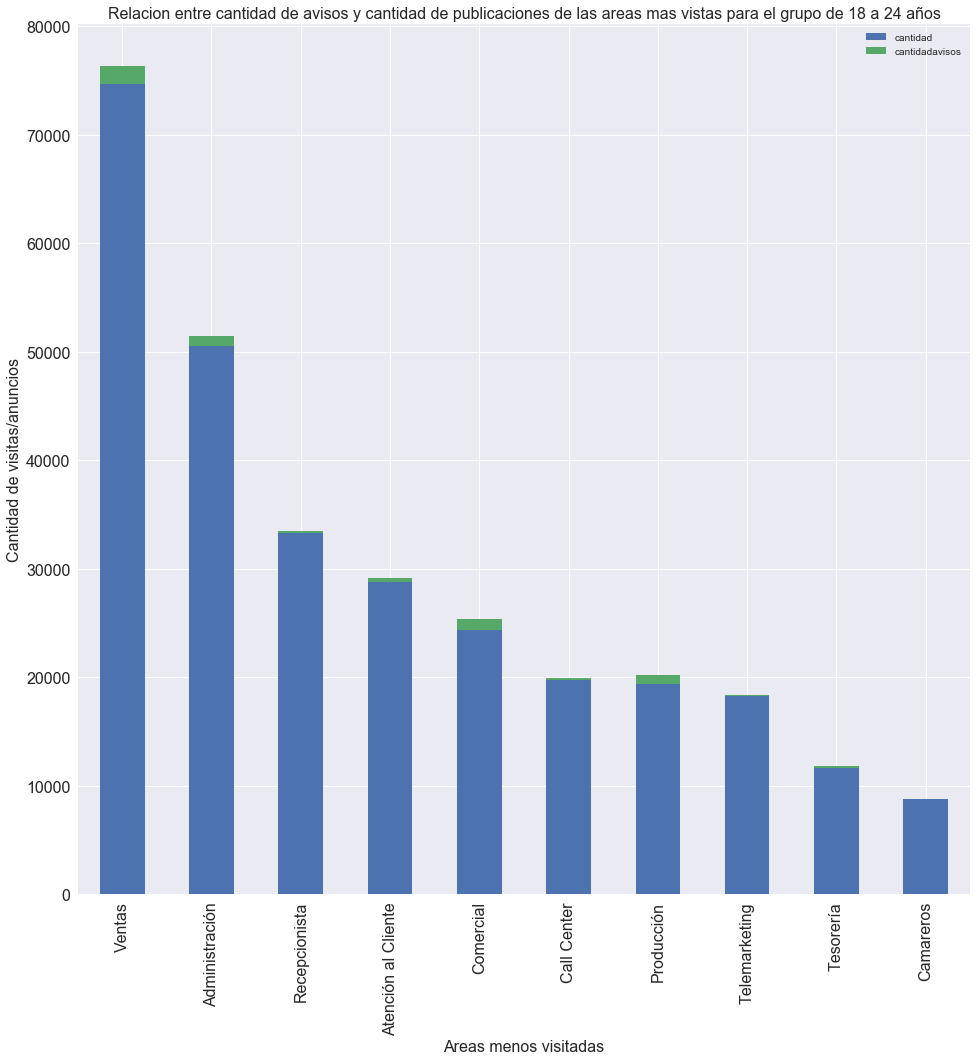

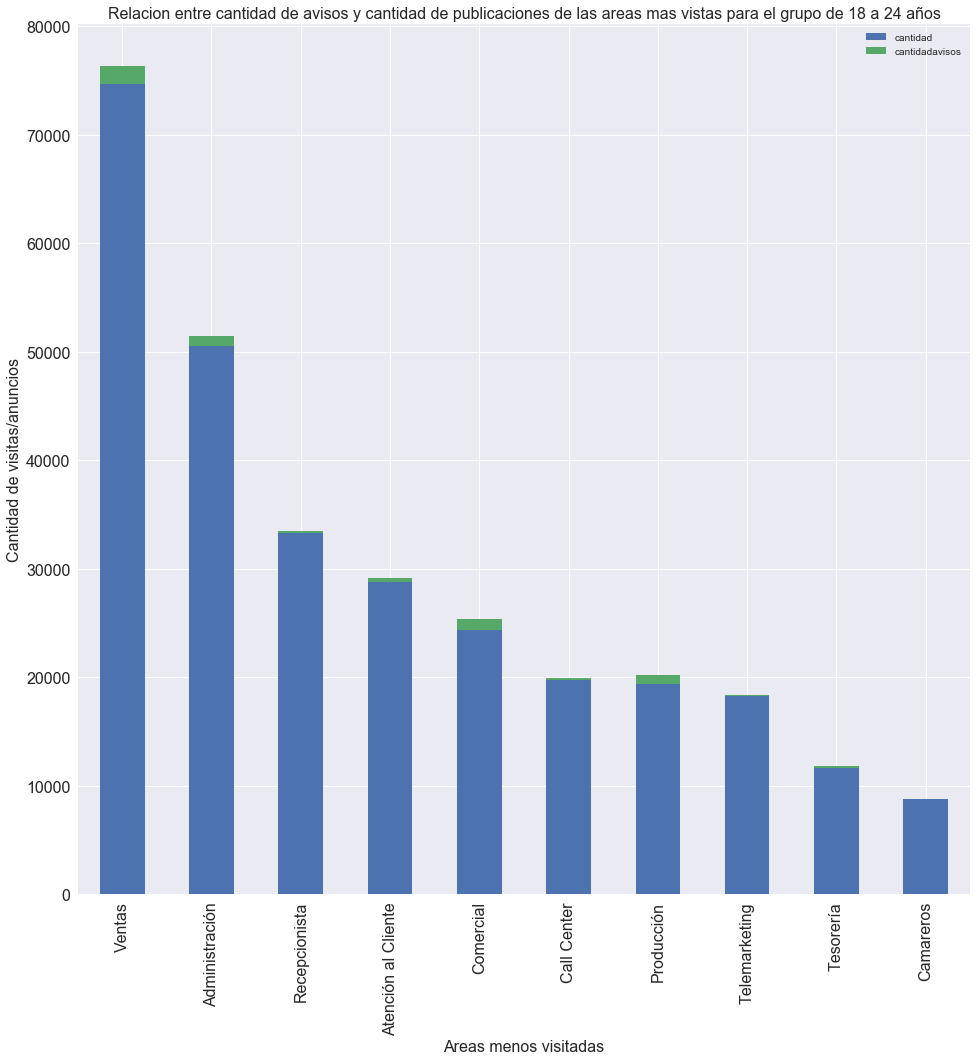

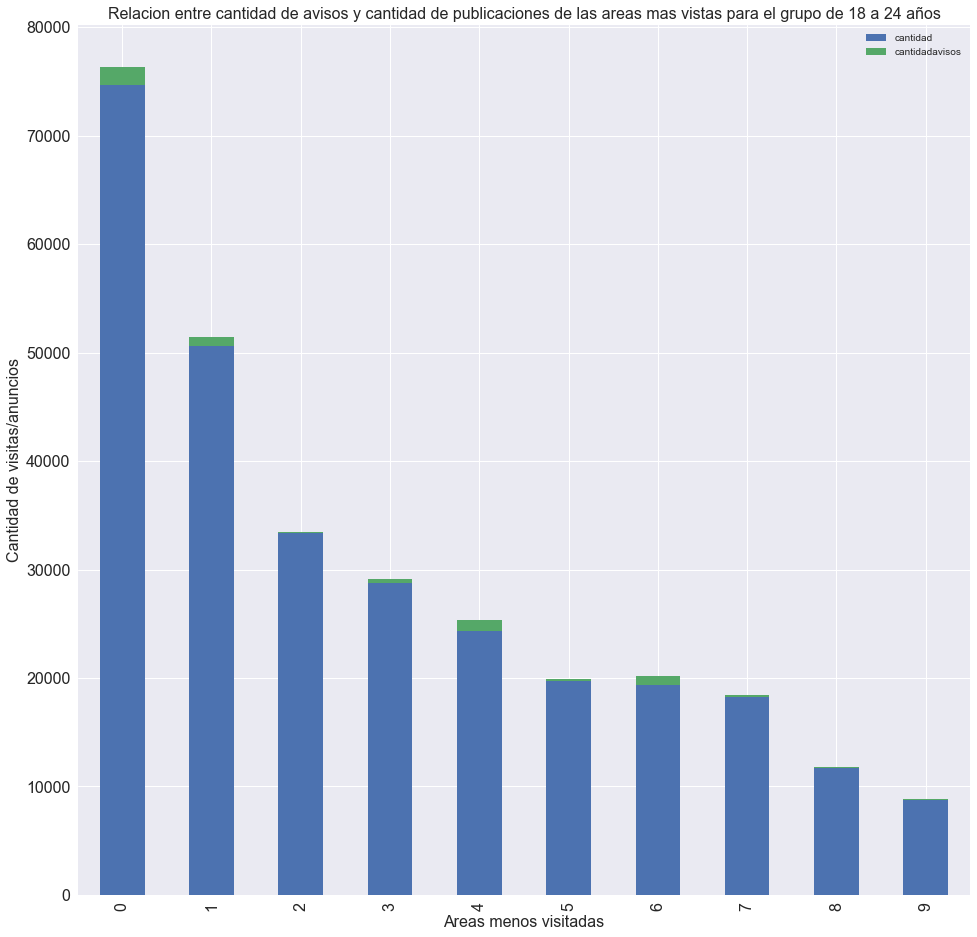

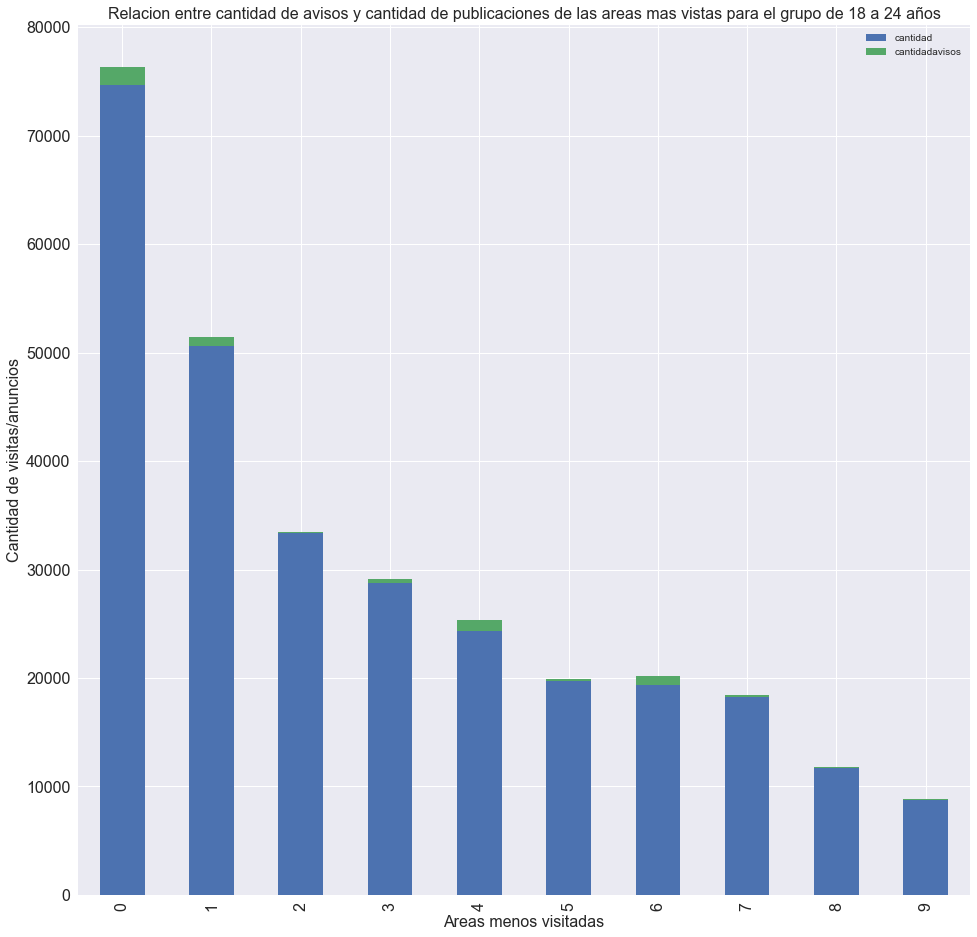

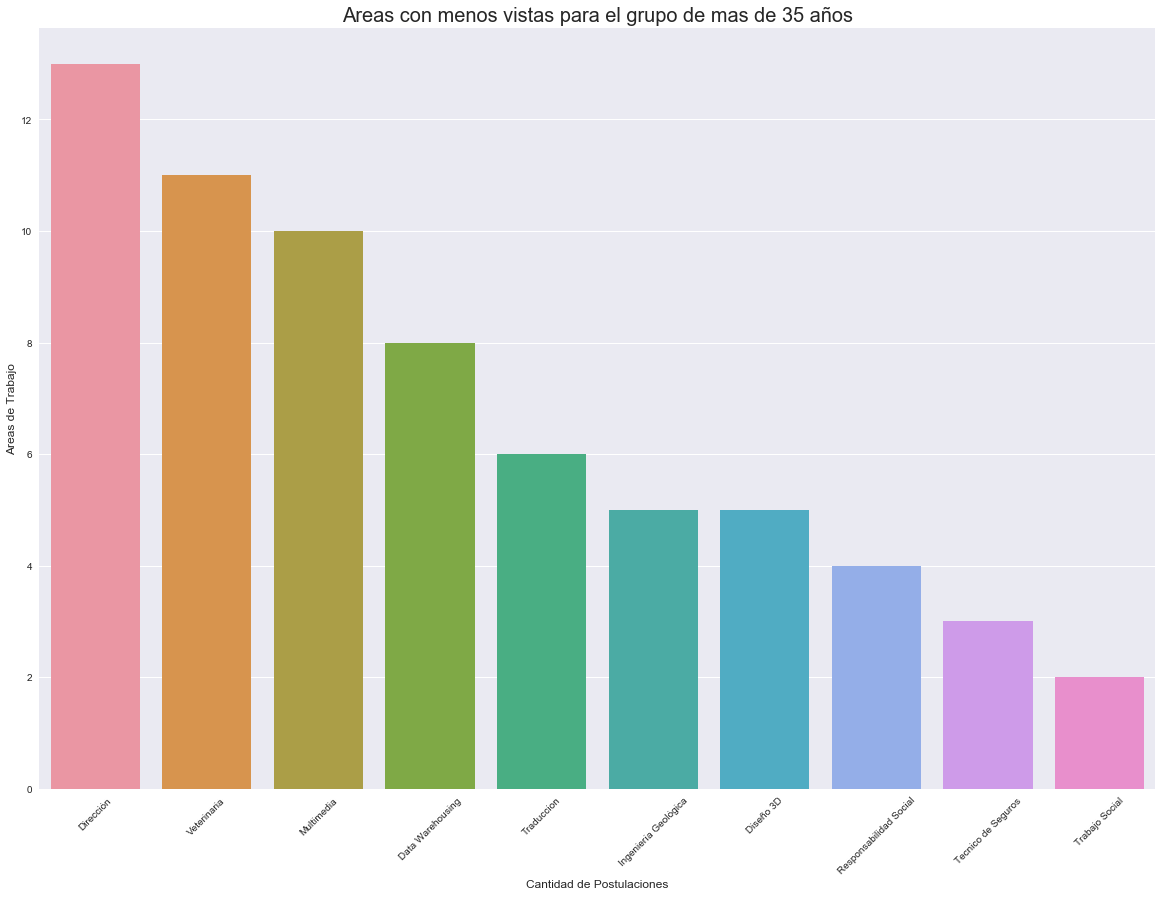

In [35]:
# Grafico que muestra las areas menos vistadas para el grupo de mas de 35 años.
plt.subplots(figsize = (20, 14))
areaMenosVisitadas3Plot = sns.barplot(x = areaMenosVisitadas3['nombre_area'], y = areaMenosVisitadas3['cantidad'], orient = 'v')
areaMenosVisitadas3Plot.set_xticklabels(areaMenosVisitadas3Plot.get_xticklabels(), rotation = 45)
areaMenosVisitadas3Plot.set_title("Areas con menos vistas para el grupo de mas de 35 años", fontsize = 20)
areaMenosVisitadas3Plot.set_xlabel("Cantidad de Postulaciones", fontsize = 12)
areaMenosVisitadas3Plot.set_ylabel("Areas de Trabajo", fontsize = 12)
plt.show()